# AI Saturdays DL Sesion 5 (RL) - Challenge Solution

## Actor Critic Method

## Introducción

Este script muestra una implementación del método Actor Critic en el entorno CartPole-V0.

### Método Actor Critic

A medida que un agente realiza acciones y se mueve a través de un entorno, aprende a asignar
el estado observado del entorno a dos posibles salidas:

1. Acción recomendada: Un valor de probabilidad para cada acción en el espacio de acción.
   La parte del agente responsable de esta salida se denomina **actor**.
2. Recompensas estimadas en el futuro: Suma de todas las recompensas que espera recibir en el
   futuro. La parte del agente responsable de esta salida es el **crítico**.

El agente y el crítico aprenden a realizar sus tareas, de forma que las acciones recomendadas
del agente maximicen las recompensas.

### CartPole-V0

Un poste está unido a un carro colocado en una pista sin fricción. El agente tiene que aplicar
fuerza para mover el carro. Se recompensa por cada paso de tiempo que el poste
permanece en posición vertical. El agente, por tanto, debe aprender a evitar que el poste se caiga.

### Referencias
 
 Este reto está adaptado de (https://keras.io/examples/rl/actor_critic_cartpole/)


Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator

### Otras referencias

- Repositorio de Github de la librería OpenAI Gym [aquí](https://github.com/openai/gym).

- Enlace a la interfaz de los environments [aquí](https://github.com/openai/gym/blob/master/gym/core.py).

- Enlace al environment del CartPole [aquí](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).

## Setup


In [64]:
import datetime
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pprint

from tensorflow import keras
from tensorflow.keras import layers

In [65]:
%matplotlib inline

In [66]:
from google.colab import drive
import sys

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The cell below are the specific requirements that should be met for this colab:

In [67]:
!pip install -r requirements_colab.txt

INFO: pip is looking at multiple versions of alabaster to determine which version is compatible with other requirements. This could take a while.
  Using cached alabaster-0.7.12-py2.py3-none-any.whl (14 kB)
INFO: pip is looking at multiple versions of absl-py to determine which version is compatible with other requirements. This could take a while.
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install albumentations==0.1.12 and imgaug==0.2.9 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested imgaug==0.2.9
    albumentations 0.1.12 depends on imgaug<0.2.7 and >=0.2.5

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR:

In [68]:
!apt-get install xvfb mesa-utils -y && apt install freeglut3-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
mesa-utils is already the newest version (8.4.0-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [69]:
!pip install -q git+https://github.com/tensorflow/docs

## Implementar la red Actor Critic

For CartPole environment, the state is represented by an array with four values:

```
### Observation Space

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |


```

The actions that the agent is able to perform is a two values array (discrete actions):

```
### Action Space

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |


```

[Reference](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

All the exercise is done through little python modules, that divides the problem into different sections; the module is store at the same path level that this notebook.

In [70]:
# path to where this notebook and the module is stored
sys.path.append("/content/drive/MyDrive/satAI/week_05/challenge/")

In [71]:
from module.env    import train_env, ENV, SEED, TRAIN_PARAMS, NUM_INPUTS, N_ACTIONS

All the gym environment is defined within tht **env.py** file; inside this py file we have defined:
  * the global seed to make results as replicable as possible
  * the global gym environment
  * the training params used for the environment

Below there is a print of the main params:

In [72]:
print(f"global environment: {ENV} \nglobal seed: {SEED}")

global environment: <TimeLimit<CartPoleEnv<CartPole-v0>>> 
global seed: 42


In [73]:
print(f"there are {NUM_INPUTS} number of inputs in the observation space and {N_ACTIONS} possible actions")

there are (4,) number of inputs in the observation space and 2 possible actions


In [77]:
for k, v in TRAIN_PARAMS.items(): print("{:<20}: {:<10}".format(k, v))

n_hidden            : 128       
learning_rate       : 0.002     
delta               : 1.0       
gamma               : 0.985     
max_episode_steps   : 200       
max_game_steps      : 25500     


---

Esta red aprende dos funciones:

1. Actor: Toma como entrada el estado de nuestro entorno y devuelve un
valor de probabilidad para cada acción en su espacio de acción.
2. Crítico: Toma como entrada el estado de nuestro entorno y devuelve
una estimación de las recompensas totales en el futuro.


Their variables are set in the `TRAIN_PARAMS` dictionary:
  * **num_inputs**: stablished by the observation_space in the gym environment
  * **n_actions**: stablished by the action_space in the gym environment
  * **nhidden**: number of neuron in the hidden layers for both RNNs.

In [78]:
from module.agents import Actor, Critic

In [79]:
actor = Actor()
actor.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_22 (Dense)            (None, 128)               640       
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


The actor takes the `NUM_INPUTS` as the input_shape and is defined with only one deep layer with `TRAIN.PARAMS.n_hidden` neurons

In [80]:
critic = Critic()
critic.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_24 (Dense)            (None, 128)               640       
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


Some other results:
- Option A - A dense layer [64] - running reward 46.0 (10k steps)
- Option B - A dense layer [64] - running reward 81.0 (10k steps)
- Option A - Two dense layers [128, 64] - running reward 43.0 (10k steps)
- Option B - Two dense layers [128, 64] - running reward 150.0 (10k steps)
- Option B - Three dense layers [128, 64, 64] - running reward 161.0 (10k steps)
- Option B - Three dense layers [256, 128, 64] - running reward 80.0 (10k steps)
- Option C - Actor with one dense layer [128] and Critic with two dense layers [128,64] with a running reward of 161 at aprox 10k steps and +185 running reward at episode 200.

## Train

The training process is divided in two file:
  * **module.compute_rewards.py**: in this module there are the functions that iterate through all the steps for each episode, and after that it computes the running reward

  * **module.compute_loss.py**: in this module it is where the loss for the agents is computed and the gradient descend is updated.


----
_[history]_

The group has tried different variations in the training setup:
  * when updating the gradient_desdend (see `update_gradient()`) it could be done either once with the sum of agents' losses or iterating through them. 
  The second option has performed better.
  * Different Actor and Critic architectures have been done to see how much faster the training is done; the above prints are the final architectures.




----

All the process for training is at `module.env.train_env` function

In [81]:
reward_history, losses_history, episode_count = train_env()

2022-04-17 21:54:10 - the running reward is 10.09     the episode reward is 29.0      at episode 10    (251 steps in total)
2022-04-17 21:54:12 - the running reward is 16.44     the episode reward is 11.0      at episode 20    (511 steps in total)
2022-04-17 21:54:16 - the running reward is 24.36     the episode reward is 96.0      at episode 30    (853 steps in total)
2022-04-17 21:54:20 - the running reward is 30.08     the episode reward is 39.0      at episode 40    (1236 steps in total)
2022-04-17 21:54:24 - the running reward is 34.83     the episode reward is 24.0      at episode 50    (1651 steps in total)
2022-04-17 21:54:29 - the running reward is 41.18     the episode reward is 48.0      at episode 60    (2157 steps in total)
2022-04-17 21:54:37 - the running reward is 63.03     the episode reward is 46.0      at episode 70    (3084 steps in total)
2022-04-17 21:54:49 - the running reward is 83.34     the episode reward is 31.0      at episode 80    (4239 steps in total)
202

The graph below represents the evolution of episode rewards and running rewards.

- The episode rewards represent each episode (game) reward.
- The running rewards represent the computed reward (95% current running reward + 5% last episode reward) 

We can see that the agent reached the maximum score (episode reward = 200) early, but it took some time to acquire enough knowledge to perform the better actions (running reward > 195).

This can be explained like this: The agent got the maximum reward even when it
still didn't learnt the best policies to follow. After this he still kept learning (that's why he gets some worse performances after getting the highest score). He finally learnt enough to be able to win the game in most of the cases.

In [84]:
from module.viz import plot_history
plt.style.use('seaborn')

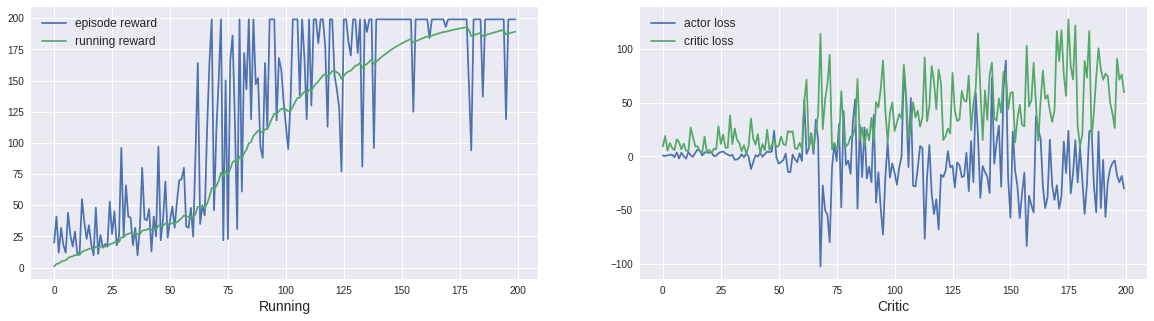

In [85]:
# Plot the episode and running rewards evolution.
fig, ax = plt.subplots(ncols = 2, figsize=(20, 5))

ax[0] = plot_history(ax[0], episode_count, reward_history, label ='reward')
ax[1] = plot_history(ax[1], episode_count, losses_history, label = 'loss')

plt.show()

Let's try to represent an episode for our CartPole simulated environment. It could be useful to understand the problem better.

OpenAI gym environment interface includes the `env.render()` method to perform this task, but it's tricky to use it in not-a-local machine (remote server) as Colab.

We need some set up.

Note: Execute the following cells in the strict order they are in the notebook.

In [86]:
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

import tensorflow_docs.vis.embed as embed

In [ ]:
# from here needs refactor !!!!!!!!!!

display = Display(visible=0, size=(400, 300))
display.start()

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)
    images = [im]

    state = tf.constant(env.reset(), dtype=tf.float32)

    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs = actor_model(state)
        action = np.argmax(np.squeeze(action_probs))
        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps.
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))

        if done:
            break

    return images

# Save the GIF image.
images = render_episode(env, actor_model, max_steps)
image_file = 'cartpole-v0.gif'

# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

In [39]:
embed.embed_file(image_file)  # Voila!

NameError: ignored

# Usando un marco de trabajo

En esta sección del reto, en lugar de decodificar un algoritmo, se utilizará un marco de trabajo de RL, en concreto, Stable Baselines (https://stable-baselines.readthedocs.io/en/master/). Este marco ofrece muchos algoritmos diferentes, aunque la mayoría de ellos son similares a los vistos en clase. 

Siga el tutorial de líneas de base estables, deberían ser unas pocas líneas de código. Además, puedes explorar la personalización de la red que se utiliza o jugar con los hiperparámetros. 


We've used the stable baselines 3 (latest version of stable baselines).

[Reference](https://stable-baselines3.readthedocs.io/en/master/)

To compute the Actor Critic we've follow the example [from the Getting Started section](https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html).

In [ ]:
import gym
from stable_baselines3 import A2C

In [ ]:
model = A2C('MlpPolicy', 'CartPole-v1')
model.learn(total_timesteps=50000)

In [ ]:
obs = env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()

    if done:
      obs = env.reset()

In [ ]:
# Other option.

In [ ]:
env = gym.make('CartPole-v1')

model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=50000)

In [ ]:
obs = env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()

    if done:
      obs = env.reset()